In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.feature_selection import RFE
from scipy.stats import pearsonr, chi2_contingency, entropy
from scipy import special 
import seaborn as sns
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from featurewiz import featurewiz
from sklearn.feature_selection import VarianceThreshold
import pickle

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_json('./test_data/data.json', lines=True)
labels = pd.read_csv('./data/labels.info', sep=',')

In [4]:
def get_dataframe(df):
    transcripts = df.columns
    dataframes = []
    for transcript in transcripts:
        df_curr_transcript = df.loc[:, transcript]
        df_curr_transcript.dropna(inplace=True)
        df_curr_transcript = list(df_curr_transcript)
        
        for position in df_curr_transcript:
            #position here is a dictionary
            for k1, v1, in position.items():
                order = list(v1.keys())[0]
                for k2, v2 in v1.items():

                    
                    n = len(v2)

                    left_dwelling_t = np.zeros(n)
                    left_sd = np.zeros(n)
                    left_mean = np.zeros(n)

                    centre_dwelling_t = np.zeros(n)
                    centre_sd = np.zeros(n)
                    centre_mean = np.zeros(n)

                    right_dwelling_t = np.zeros(n)
                    right_sd = np.zeros(n)
                    right_mean = np.zeros(n)

                    for i in range(n):
                        left_dwelling_t[i] = v2[i][0]
                        left_sd[i] = v2[i][1]
                        left_mean[i] = v2[i][2]

                        centre_dwelling_t[i] = v2[i][3]
                        centre_sd[i] = v2[i][4]
                        centre_mean[i] = v2[i][5]
                        
                        right_dwelling_t[i] = v2[i][6]
                        right_sd[i] = v2[i][7]
                        right_mean[i] = v2[i][8]

                    left_dwelling_t_mean = np.mean(left_dwelling_t)
                    left_dwelling_t_var = np.var(left_dwelling_t)
                    left_sd_mean = np.mean(left_sd)
                    left_sd_var = np.var(left_sd)
                    left_mean_mean = np.mean(left_mean)
                    left_mean_var = np.var(left_mean)

                    centre_dwelling_t_mean = np.mean(centre_dwelling_t)
                    centre_dwelling_t_var = np.var(centre_dwelling_t)
                    centre_sd_mean = np.mean(centre_sd)
                    centre_sd_var = np.var(centre_sd)
                    centre_mean_mean = np.mean(centre_mean)
                    centre_mean_var = np.var(centre_mean)
                    
                    right_dwelling_t_mean = np.mean(right_dwelling_t)
                    right_dwelling_t_var = np.var(right_dwelling_t)
                    right_sd_mean = np.mean(right_sd)
                    right_sd_var = np.var(right_sd)
                    right_mean_mean = np.mean(right_mean)
                    right_mean_var = np.var(right_mean)

                    
                    
                final_order = order[:3] + order[5:]
                curr_dataframe = pd.DataFrame({'transcript_id':[transcript], 'order': [final_order], 'curr_pos': [k1], 
                                               'mean_ldt': [left_dwelling_t_mean], 'var_ldt':[left_dwelling_t_var], 'mean_lsd': [left_sd_mean], 'var_lsd': [left_sd_var], 'mean_lm':[left_mean_mean], 'var_lm': [left_mean_var], 
                                               'mean_cdt': [centre_dwelling_t_mean], 'var_cdt':[centre_dwelling_t_var] , 'mean_csd':[centre_sd_mean], 'var_csd': [centre_sd_var], 'mean_cm': [centre_mean_mean], 'var_cm': [centre_mean_var],  
                                               'mean_rdt': [right_dwelling_t_mean], 'var_rdt':[right_dwelling_t_var], 'mean_rsd': [right_sd_mean], 'var_rsd':[right_sd_var], 'mean_rm': [right_mean_mean], 'var_rm':[right_mean_var], 
                                               'num_reads': n})   
                dataframes.append(curr_dataframe)
    final_df = pd.concat(dataframes)
    final_df['curr_pos'] = final_df['curr_pos'].astype('int64')
    final_df['A_count'] = final_df['order'].apply(lambda x: x.count('A'))
    final_df['C_count'] = final_df['order'].apply(lambda x: x.count('C'))
    final_df['G_count'] = final_df['order'].apply(lambda x: x.count('G'))
    final_df['T_count'] = final_df['order'].apply(lambda x: x.count('T'))

    return final_df 

In [5]:
df1 = get_dataframe(df)

In [6]:
df1.head(10)

,transcript_id,order,curr_pos,mean_ldt,var_ldt,mean_lsd,var_lsd,mean_lm,var_lm,mean_cdt,var_cdt,mean_csd,var_csd,mean_cm,var_cm,mean_rdt,var_rdt,mean_rsd,var_rsd,mean_rm,var_rm,num_reads,A_count,C_count,G_count,T_count
0,ENST00000000233,AAGCA,244,0.008264,0.000029,4.223784,3.396742,123.702703,24.446749,0.009373,0.000029,7.382162,10.907635,125.913514,7.646574,0.007345,0.000021,4.386989,8.446146,80.570270,6.361332,185,3,1,1,0
0,ENST00000000233,CAATG,261,0.006609,0.000013,3.216424,2.853284,109.681395,8.887445,0.006813,0.000014,3.226535,1.530279,107.889535,12.436402,0.007710,0.000021,3.016599,2.150021,94.290698,6.212704,172,2,1,1,1
0,ENST00000000233,GAAAG,316,0.007570,0.000020,2.940541,1.718991,105.475676,2.227787,0.007416,0.000025,3.642703,0.798308,98.947027,10.264437,0.007555,0.000020,2.087146,0.640794,89.364324,2.203268,185,3,0,2,0
0,ENST00000000233,AGAAT,332,0.010620,0.000037,6.476350,6.048240,129.355000,10.258975,0.008632,0.000021,2.899200,1.942868,97.836500,3.717218,0.006102,0.000013,2.236520,0.550225,89.154000,12.214584,200,3,0,1,1
0,ENST00000000233,AGGAA,368,0.010701,0.000051,6.415051,7.525298,117.924242,7.100321,0.011479,0.000029,5.870303,3.076145,121.954545,4.740358,0.010019,0.000035,4.260253,1.800486,85.178788,5.659853,198,3,0,2,0
0,ENST00000000233,AGAAC,404,0.009011,0.000018,6.385260,3.973890,128.046875,8.336344,0.008555,0.000022,2.938281,1.863238,96.858333,2.700868,0.005798,0.000013,2.056797,0.318190,91.591146,17.607474,192,3,1,1,0
0,ENST00000000233,TGGAG,431,0.008683,0.000036,3.348642,1.127618,116.864198,3.882792,0.007249,0.000030,5.648333,6.265851,121.345679,12.695321,0.007839,0.000024,2.731636,1.290797,85.971605,3.598083,162,1,0,3,1
0,ENST00000000233,ATGCG,440,0.006788,0.000018,4.521182,1.838364,96.130542,14.376112,0.008527,0.000026,9.343350,7.579856,119.669951,11.383678,0.007414,0.000022,3.505099,2.599269,81.061084,3.443855,203,1,1,2,1
0,ENST00000000233,TGATC,471,0.006060,0.000014,8.128495,4.569732,120.597087,17.648341,0.006997,0.000011,3.058350,1.067425,101.607282,4.947957,0.006358,0.000019,1.938034,0.445716,92.542233,3.920207,206,1,1,1,2
0,ENST00000000233,AGGAT,539,0.011070,0.000051,5.953696,2.660317,116.989130,7.445534,0.008996,0.000027,7.052391,8.220527,119.538043,12.759422,0.006398,0.000016,3.482826,2.751982,81.005978,12.532084,184,2,0,2,1


In [7]:
df1["relative_pos"] = df1.groupby("transcript_id")["curr_pos"].rank()
df1["relative_pos"] = df1["relative_pos"].astype(int)

In [9]:
df1 = pd.merge(df1, labels, how='left',left_on=['transcript_id', 'curr_pos'], right_on=['transcript_id', 'transcript_position'])
df1 = df1.drop(['transcript_position'], axis='columns')
df2 = df1.copy()
df2['order_1'] = df2['order'].apply(lambda x: x[0])
df2['order_2'] = df2['order'].apply(lambda x: x[1])
df2['order_3'] = df2['order'].apply(lambda x: x[2])
df2['order_4'] = df2['order'].apply(lambda x: x[3])
df2['order_5'] = df2['order'].apply(lambda x: x[4])



#categorical data
categorical_cols = ['order_1', 'order_2', 'order_3',
       'order_4', 'order_5']

#import pandas as pd
df3 = pd.get_dummies(df2, columns = categorical_cols)

Train Test Split

In [10]:
genes = list(labels['gene_id'].unique())
train_genes, test_genes = train_test_split(genes, train_size = 0.8, random_state=42)
train_labels = labels[labels['gene_id'].isin(train_genes)]
test_labels = labels[labels['gene_id'].isin(test_genes)]
print(f'Imbalance in train labels: {train_labels.label.value_counts()[0]/train_labels.label.value_counts()[1]}')
print(f'Imbalance in test labels: {test_labels.label.value_counts()[0]/test_labels.label.value_counts()[1]}')

Imbalance in train labels: 20.6593603220756
Imbalance in test labels: 23.899402390438247


In [11]:
X_train = pd.merge(train_labels, df3, how='inner',left_on=['gene_id', 'transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])
X_test = pd.merge(test_labels, df3, how='inner',left_on=['gene_id','transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])

In [12]:
y_train = np.asarray(X_train['label'])
y_test = np.asarray(X_test['label'])

Drop unnecessary columns

In [13]:
# Drop unnecessary columns in X_test
X_test = X_test.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order', 'curr_pos'], axis=1)

In [14]:
# Drop unnecessary columns in X_train
X_train = X_train.drop(['transcript_id', 'transcript_position', 'order', 'curr_pos'], axis=1) # We shall drop gene_id and label after doing manual cross validation

Now let us check the base score using an untuned XGBoost on X_train and y_train where we only use columns that were provided to us.

In [51]:
columns_provided = ['mean_ldt', 'mean_lsd', 'mean_lm', 
                    'mean_cdt', 'mean_csd', 'mean_cm', 
                    'mean_rdt', 'mean_rsd', 'mean_rm', 'order_1_A', 'order_1_C', 'order_1_G',
       'order_1_T', 'order_2_A', 'order_2_G', 'order_2_T', 'order_3_A',
       'order_3_G', 'order_4_A', 'order_4_C', 'order_4_T', 'order_5_A',
       'order_5_C', 'order_5_G', 'order_5_T']
base_train = X_train[columns_provided]
base_test = X_test[columns_provided]
scaler = MinMaxScaler()
scaled_base_train = scaler.fit_transform(base_train)
scaled_base_test = scaler.transform(base_test)
base_model = XGBClassifier()
base_model2 = LogisticRegression()
base_model.fit(scaled_base_train, y_train)
base_model2.fit(scaled_base_train, y_train)

base_pred = base_model.predict(scaled_base_test)
base_score = base_model.predict_proba(scaled_base_test)[:, 1]

base_pred2 = base_model2.predict(scaled_base_test)
base_score2 = base_model2.predict_proba(scaled_base_test)[:, 1]

print(f"Base xgb ROCAUC: {roc_auc_score(y_test, base_score)}")
print(f"Base xgb PRAUC: {average_precision_score(y_test, base_score)}")

print(f"Base lr ROCAUC: {roc_auc_score(y_test, base_score2)}")
print(f"Base lr PRAUC: {average_precision_score(y_test, base_score2)}")

Base xgb ROCAUC: 0.8836846819847096
Base xgb PRAUC: 0.402271144888392
Base lr ROCAUC: 0.8594179647320284
Base lr PRAUC: 0.3609001383474221


With and without scaling, the base scores:
- Base xgb ROCAUC: 0.8836846819847096
- Base xgb PRAUC: 0.402271144888392
- Base lr ROCAUC: 0.8594179647320284
- Base lr PRAUC: 0.3609001383474221

Removing the order columns: 

In [53]:
columns_provided = ['mean_ldt', 'mean_lsd', 'mean_lm', 
                    'mean_cdt', 'mean_csd', 'mean_cm', 
                    'mean_rdt', 'mean_rsd', 'mean_rm']
scaled_base_train = X_train[columns_provided]
scaled_base_test = X_test[columns_provided]
scaler = MinMaxScaler()
#scaled_base_train = scaler.fit_transform(base_train)
#scaled_base_test = scaler.transform(base_test)
base_model = XGBClassifier()
base_model2 = LogisticRegression()
base_model.fit(scaled_base_train, y_train)
base_model2.fit(scaled_base_train, y_train)

base_pred = base_model.predict(scaled_base_test)
base_score = base_model.predict_proba(scaled_base_test)[:, 1]

base_pred2 = base_model2.predict(scaled_base_test)
base_score2 = base_model2.predict_proba(scaled_base_test)[:, 1]

print(f"Base xgb ROCAUC: {roc_auc_score(y_test, base_score)}")
print(f"Base xgb PRAUC: {average_precision_score(y_test, base_score)}")

print(f"Base lr ROCAUC: {roc_auc_score(y_test, base_score2)}")
print(f"Base lr PRAUC: {average_precision_score(y_test, base_score2)}")

Base xgb ROCAUC: 0.8691358342416954
Base xgb PRAUC: 0.38032231752551915
Base lr ROCAUC: 0.7099894234273574
Base lr PRAUC: 0.08386597974768656


Scaling affects lr -> with scaling, it performs slightly better:
- Base ROCAUC: 0.8691358342416954
- Base PRAUC: 0.38032231752551915
- Base lr ROCAUC: 0.7238581410967924
- Base lr PRAUC: 0.0939233575854529

Okay so now we know what our base scores should be near, for a poor model and a kinda easily overfit model.

Now we shall focus on feature extraction using cross validation. First, we use Variance Threshold to identify which features don't change 80% of the time.

In [56]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8))) #we remove columns that don't change 80% in all of the samples. 
cat_cols = ['order_1_A',
       'order_1_C', 'order_1_G', 'order_1_T', 'order_2_A', 'order_2_G',
       'order_2_T', 'order_3_A', 'order_3_G', 'order_4_A', 'order_4_C',
       'order_4_T', 'order_5_A', 'order_5_C', 'order_5_G', 'order_5_T']
extracted_cat_cols = sel.fit(X_train[cat_cols])

In [57]:
cat_keep = extracted_cat_cols.get_feature_names_out()

In [58]:
for col in cat_cols:
    if col not in cat_keep:
        print(f"Remove column: {col}")

Remove column: order_1_C


In [15]:
X_train = X_train.drop(['order_1_C'], axis=1)
X_test = X_test.drop(['order_1_C'], axis=1)

Manual CV

In [16]:
num_genes = len(train_genes)
validation_set_size = int(.2 * num_genes)
#train_indices = np.array([i for i in range(num_genes)])

import random
random.seed(10)

s = list(range(num_genes))
random.shuffle(s)

set1 = s[-validation_set_size:]
del s[-validation_set_size:]

set2 = s[-validation_set_size:]
del s[-validation_set_size:]

set3 = s[-validation_set_size:]
del s[-validation_set_size:]

set4 = s[-validation_set_size:]
del s[-validation_set_size:]

set5 = s


genes_s1 = [train_genes[i] for i in set1]
genes_s2 = [train_genes[i] for i in set2]
genes_s3 = [train_genes[i] for i in set3]
genes_s4 = [train_genes[i] for i in set4]
genes_s5 = [train_genes[i] for i in set5]

s1_train = X_train[X_train['gene_id'].isin(genes_s1)]
s2_train = X_train[X_train['gene_id'].isin(genes_s2)]
s3_train = X_train[X_train['gene_id'].isin(genes_s3)]
s4_train = X_train[X_train['gene_id'].isin(genes_s4)]
s5_train = X_train[X_train['gene_id'].isin(genes_s5)]

In [17]:
s1_train = s1_train.drop(['gene_id'], axis=1)
s2_train = s2_train.drop(['gene_id'], axis=1)
s3_train = s3_train.drop(['gene_id'], axis=1)
s4_train = s4_train.drop(['gene_id'], axis=1)
s5_train = s5_train.drop(['gene_id'], axis=1)

sets = [s1_train, s2_train, s3_train, s4_train, s5_train]

In [18]:
for datas in sets:
    print(f"Imbalance: {datas.label.value_counts()[0]/datas.label.value_counts()[1]}")
    print(f"Number of samples: {datas.shape[0]}")

Imbalance: 21.661555312157724
Number of samples: 20690
Imbalance: 20.399332591768633
Number of samples: 19238
Imbalance: 21.12316384180791
Number of samples: 19579
Imbalance: 20.554176072234764
Number of samples: 19097
Imbalance: 19.53490990990991
Number of samples: 18235


In [19]:
#data is a list of the validation sets
#model should be called already. 
def cross_val(model, data):
    precision = 0
    recall = 0
    aucroc = 0
    prauc = 0

    for i in range(5):
        val = data[i]
        y_val = np.asarray(val['label'])
        X_val = val.drop(['label'], axis=1).values

        train = pd.concat(data[:i] + data[i+1:], axis=0)
        y_train = np.asarray(train['label'])
        X_train = train.drop(['label'], axis=1).values

        # scaler = MinMaxScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_val_scaled = scaler.transform(X_val)
        # define the sampling method
        # undersample = NearMiss(version=1, n_neighbors=3)
        # oversample = RandomOverSampler(sampling_strategy='minority')
        # X_over, y_over = oversample.fit_resample(X_train_scaled, y_train)

        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        precision += precision_score(y_val, y_pred)
        recall += recall_score(y_val, y_pred)
        aucroc += roc_auc_score(y_val, y_score)
        prauc += average_precision_score(y_val, y_score)
    
    precision /= 5
    recall /= 5
    aucroc /= 5
    prauc /= 5

    results = {'precision': precision, 'recall': recall, 'aucroc': aucroc, 'prauc': prauc}
    return precision, recall, aucroc, prauc

In [20]:
def plot_lines(n, p, r, a, pr, xl):
    plt.plot(n, p, color='red', label='precision')
    plt.plot(n, r, color='blue', label='recall')
    plt.plot(n, a, color='green', label='auc')
    plt.plot(n, pr, color='brown', label='prauc')
    plt.legend()
    plt.xlabel(xl)
    plt.ylabel('score')
    plt.show()

In [68]:
features = [39, 35, 30, 25, 20, 15, 10, 5]
model = XGBClassifier()
store_auc = []
store_prauc = []
for feature in features:
    selector = RFE(model, n_features_to_select=feature, step=1)
    pr, rc, auc, prauc = cross_val(selector, sets)
    store_auc.append(auc)
    store_prauc.append(prauc)

These are the auc scores according to the feature selection above:
0.9126840976336084,
 0.9127059101584599,
 0.9126115497299656,
 0.9111876335196115,
 0.906475367856882,
 0.9042322552136763,
 0.892146304633426,
 0.8336659686176219


The are the prauc scores according to the feature selection above: 0.4669365706894464,
 0.4638434423715432,
 0.4682896772717358,
 0.46856228285250057,
 0.443107295342386,
 0.4480570223885364,
 0.4249699329252875,
 0.27274010788905584

In [71]:
idx_prauc = np.argmax(np.array(store_prauc))
idx_auc = np.argmax(np.array(store_auc))

In [72]:
idx_prauc

3

In [73]:
idx_auc

1

We shall use 25 features

In [74]:
model = XGBClassifier()
selector = RFE(model, n_features_to_select=25, step=1)
selector = selector.fit(X_train.drop(['gene_id', 'label'], axis=1), y_train)
selector.get_feature_names_out()

array(['mean_lsd', 'mean_lm', 'var_lm', 'mean_csd', 'var_csd', 'mean_cm',
       'var_cm', 'mean_rsd', 'mean_rm', 'var_rm', 'num_reads', 'G_count',
       'T_count', 'relative_pos', 'order_1_A', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_3_A', 'order_4_A', 'order_4_C', 'order_4_T',
       'order_5_A', 'order_5_G', 'order_5_T'], dtype=object)

In [21]:
filtered_cols = ['mean_lsd', 'mean_lm', 'var_lm', 'mean_csd', 'var_csd', 'mean_cm',
       'var_cm', 'mean_rsd', 'mean_rm', 'var_rm', 'num_reads', 'G_count',
       'T_count', 'relative_pos', 'order_1_A', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_3_A', 'order_4_A', 'order_4_C', 'order_4_T',
       'order_5_A', 'order_5_G', 'order_5_T']

In [22]:
rfe_train1 = X_train[['mean_lsd', 'mean_lm', 'var_lm', 'mean_csd', 'var_csd', 'mean_cm',
       'var_cm', 'mean_rsd', 'mean_rm', 'var_rm', 'num_reads', 'G_count',
       'T_count', 'relative_pos', 'order_1_A', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_3_A', 'order_4_A', 'order_4_C', 'order_4_T',
       'order_5_A', 'order_5_G', 'order_5_T']]

rfe_test1 = X_test[['mean_lsd', 'mean_lm', 'var_lm', 'mean_csd', 'var_csd', 'mean_cm',
       'var_cm', 'mean_rsd', 'mean_rm', 'var_rm', 'num_reads', 'G_count',
       'T_count', 'relative_pos', 'order_1_A', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_3_A', 'order_4_A', 'order_4_C', 'order_4_T',
       'order_5_A', 'order_5_G', 'order_5_T']]

rfe_model = XGBClassifier()
rfe_model.fit(rfe_train1.values, y_train)
y_pred = rfe_model.predict(rfe_test1.values)
y_score = rfe_model.predict_proba(rfe_test1.values)[:, 1]

# Data to plot precision - recall curve
rfe_precision, rfe_recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(rfe_recall, rfe_precision)
print(f"rfe xgb actual pr auc: {auc_precision_recall}")
print(f"rfe xgb AUCROC Score: {roc_auc_score(y_test, y_score)}")
print(f"rfe xgb PR AUC: {average_precision_score(y_test, y_score)}")
print(f"rfe xgb precision: {precision_score(y_test, y_pred)}")
print(f"rfe xgb recall: {recall_score(y_test, y_pred)}")

rfe xgb actual pr auc: 0.46520702452630464
rfe xgb AUCROC Score: 0.9124642916145379
rfe xgb PR AUC: 0.4660771594762442
rfe xgb precision: 0.6281800391389433
rfe xgb recall: 0.3197211155378486


In [23]:
def prauc_score(y_true, y_score):
    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

In [24]:
eta = np.linspace(0.05, 0.15, 5)
max_depth = np.linspace(2, 15, 6)
alpha = np.linspace(0, 10, 4)
scale_pos_weight = np.linspace(4.25, 5.25, 4)
ld = np.linspace(0, 10, 4)

In [86]:
sets2 = []
for set in sets:
    new_set = set[['label','mean_lsd', 'mean_lm', 'var_lm', 'mean_csd', 'var_csd', 'mean_cm',
       'var_cm', 'mean_rsd', 'mean_rm', 'var_rm', 'num_reads', 'G_count',
       'T_count', 'relative_pos', 'order_1_A', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_3_A', 'order_4_A', 'order_4_C', 'order_4_T',
       'order_5_A', 'order_5_G', 'order_5_T']]
    sets2.append(new_set)
    

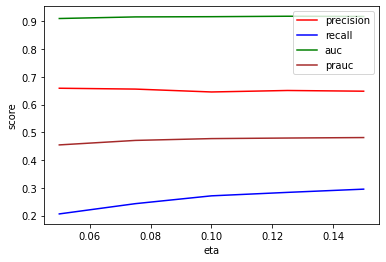

In [89]:
prec = []
rec = []
area = []
prarea = []

for val in eta:
    xgb = XGBClassifier(eta=val)
    precision, recall, aucroc, prauc = cross_val(xgb, sets2)
    prec.append(precision)
    rec.append(recall)
    area.append(aucroc)
    prarea.append(prauc)
plot_lines(eta, prec, rec, area, prarea, 'eta')

Best eta=0.15

Im at val=4.25
Im at val=4.583333333333333
Im at val=4.916666666666667
Im at val=5.25


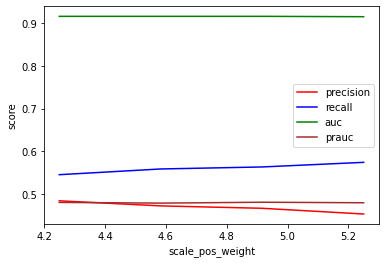

In [96]:
prec = []
rec = []
area = []
prarea = []

for val in scale_pos_weight:
    print(f"Im at val={val}")
    xgb = XGBClassifier(eta=0.15, scale_pos_weight=val)
    precision, recall, aucroc, prauc = cross_val(xgb, sets2)
    prec.append(precision)
    rec.append(recall)
    area.append(aucroc)
    prarea.append(prauc)
plot_lines(scale_pos_weight, prec, rec, area, prarea, 'scale_pos_weight')

4.9 seems good for scale pos weight

Im at val=2.0
Im at val=4.6
Im at val=7.2
Im at val=9.8
Im at val=12.4
Im at val=15.0


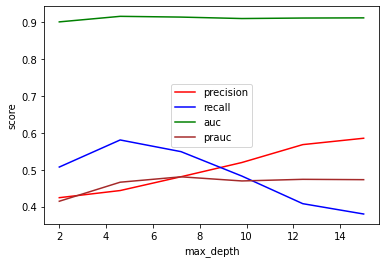

In [97]:
prec = []
rec = []
area = []
prarea = []

for val in max_depth:
    print(f"Im at val={val}")
    xgb = XGBClassifier(eta=0.15, scale_pos_weight=4.9, max_depth=int(val))
    precision, recall, aucroc, prauc = cross_val(xgb, sets2)
    prec.append(precision)
    rec.append(recall)
    area.append(aucroc)
    prarea.append(prauc)
plot_lines(max_depth, prec, rec, area, prarea, 'max_depth')

max_depth = 7 seems good 

In [25]:
X_train1 = X_train[filtered_cols]
X_test1 = X_test[filtered_cols]
tuned_xgb= XGBClassifier(eta=0.15, scale_pos_weight=4.9, max_depth=7)
tuned_xgb.fit(X_train1.values, y_train)
y_pred = tuned_xgb.predict(X_test1.values)
y_score = tuned_xgb.predict_proba(X_test1.values)[:, 1]
print(f"tuned xgb AUCROC Score: {roc_auc_score(y_test, y_score)}")
print(f"tuned xgb PR AUC: {average_precision_score(y_test, y_score)}")
print(f"tuned xgb Actual PR AUC {prauc_score(y_test, y_score)}")
print(f"tuned xgb precision: {precision_score(y_test, y_pred)}")
print(f"tuned xgb recall: {recall_score(y_test, y_pred)}")


tuned xgb AUCROC Score: 0.9172894170349234
tuned xgb PR AUC: 0.4748743985438804
tuned xgb Actual PR AUC 0.4742743004269667
tuned xgb precision: 0.4510913500404204
tuned xgb recall: 0.5557768924302788


In [102]:
filtered_cols

['mean_lsd',
 'mean_lm',
 'var_lm',
 'mean_csd',
 'var_csd',
 'mean_cm',
 'var_cm',
 'mean_rsd',
 'mean_rm',
 'var_rm',
 'num_reads',
 'G_count',
 'T_count',
 'relative_pos',
 'order_1_A',
 'order_1_T',
 'order_2_A',
 'order_2_G',
 'order_3_A',
 'order_4_A',
 'order_4_C',
 'order_4_T',
 'order_5_A',
 'order_5_G',
 'order_5_T']

In [28]:
# save the model to disk
filename = './saved_models/xgb_917.sav'
pickle.dump(tuned_xgb, open(filename, 'wb'))

In [31]:
filtered_cols.extend(['transcript_id', 'order', 'curr_pos', 'gene_id', 'label'])

In [34]:
rfe1 = df3[filtered_cols]
rfe1.to_csv('./data/rfe1.csv')